# NLP using LSTM

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Flatten, Conv1D, GRU, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
import pandas as pd
import numpy as np

# Preprocessing on Data
# Removing emojis from the chat

WhatsApp chat contains a lot of emojis. So need to filter out the input.

In [2]:
import sys
#This will read emojis as well
non_bmp_map = dict.fromkeys(range(0x10000, sys.maxunicode + 1), 0xfffd)

data = open("chat.txt",encoding="unicode-escape").read()
corpus = data.lower().split("\n")
corpus = corpus[1:]

input_data = []
i = 0
for line in corpus:
    text = line.translate(non_bmp_map)
    input_data.append(line)
    if len(text.split("-")) == 2:
        _,b = text.split("-")
        if (("rp" in b) & ((len(b.split(":")) == 2))):
            _,j = b.split(":")
            if (not "media omitted" in j):
                input_data.append(j)
len(input_data)
print(input_data[:5])

['28/08/18, 10:16 am - mummy: bhiya', "28/08/18, 10:16 am - mummy: aa no par bhi what's app kri didhu", '28/08/18, 10:16 am - mummy: mummy jode j hse', '28/08/18, 10:17 am - mummy: aetle ame bhar hoe ae to bhi tre vat thay ghre', '28/08/18, 12:52 pm - rp: naaa']


In [3]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(input_data)
total_words = len(tokenizer.word_index) + 1

input_sentences = []
for line in input_data:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1,len(token_list)):
        n_gram = token_list[:i+1]
        input_sentences.append(n_gram)
        
max_sequence_len = max([len(i) for i in input_sentences])
input_sentences = np.array(pad_sequences(input_sentences, padding='pre', maxlen = max_sequence_len))

training_data = input_sentences[:,:-1]
labels = input_sentences[:,-1]

training_labels = tf.keras.utils.to_categorical(labels, num_classes = total_words)

In [4]:
from tensorflow.keras import regularizers

model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150,return_sequences = True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [5]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 36, 64)            92800     
_________________________________________________________________
bidirectional (Bidirectional (None, 36, 300)           258000    
_________________________________________________________________
dropout (Dropout)            (None, 36, 300)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               320800    
_________________________________________________________________
dense (Dense)                (None, 725)               145725    
_________________________________________________________________
dense_1 (Dense)              (None, 1450)              1052700   
Total params: 1,870,025
Trainable params: 1,870,025
Non-trainable params: 0
______________________________________________

In [11]:
history = model.fit(training_data, training_labels,batch_size=500, epochs = 7)

Train on 16599 samples
Epoch 1/7
16599/16599 [==============================] - 92s 6ms/sample - loss: 3.0860 - accuracy: 0.3574
Epoch 2/7
16599/16599 [==============================] - 86s 5ms/sample - loss: 3.0575 - accuracy: 0.3586
Epoch 3/7
16599/16599 [==============================] - 98s 6ms/sample - loss: 3.0304 - accuracy: 0.3612
Epoch 4/7
16599/16599 [==============================] - 97s 6ms/sample - loss: 3.0040 - accuracy: 0.3674
Epoch 5/7
16599/16599 [==============================] - 98s 6ms/sample - loss: 2.9810 - accuracy: 0.3686
Epoch 6/7
16599/16599 [==============================] - 105s 6ms/sample - loss: 2.9595 - accuracy: 0.3752
Epoch 7/7
16599/16599 [==============================] - 105s 6ms/sample - loss: 2.9354 - accuracy: 0.3747


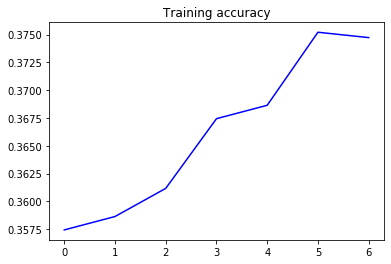

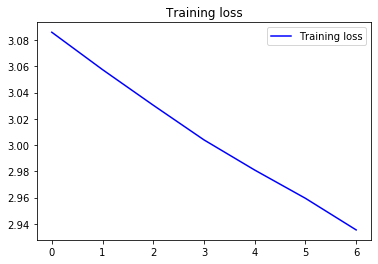

In [12]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title("Training accuracy")
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [34]:
seed_text = "kem"
next_words = 12
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1,padding='pre')
    predicted = model.predict_classes(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    if output_word not in seed_text:
        seed_text += " " + output_word
print(seed_text)

kem karu 6u


### References

1. https://www.tensorflow.org/tutorials/text/text_generation
2. "Natural Language Processing in TensorFlow" by deeplearning.ai from coursera.org